# **Libraries.**


In [ ]:
'''
    Import related libraries'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

import cv2
from skimage import filters, morphology, measure
from google.colab import files
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, LinearLocator, FuncFormatter
from scipy.ndimage import gaussian_filter1d


# **Upload.**


In [ ]:
'''
   Upload'''
uploaded = files.upload();
file_path = list(uploaded.keys())[0];
sem_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE);

  # Ensure image is uint8//
sem_image = sem_image.astype(np.uint8)

  # Image dimensions//
height_pixels, width_pixels = sem_image.shape; # Extract height and width.
total_pixels = width_pixels * height_pixels;
print(f"Width: {width_pixels}, Height: {height_pixels}, Total Pixels: {total_pixels}");


Saving Hole.png to Hole (2).png
Width: 654, Height: 657, Total Pixels: 429678


# **Processing.**


# *Image evaluation and roundness*

In [ ]:
'''
   Image processing for contour details'''
# Convert grayscale SEM image into a binary mask//
_, binary = cv2.threshold(sem_image, 50, 255, cv2.THRESH_BINARY_INV);
print(f"Binary shape: {binary.shape}");

# Contour Extraction//
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE); # To find outer boundaries of white regions in a binary image.
hole_contour = max(contours, key=cv2.contourArea); # Selects the largest contour from the list.
print(f"Hole contour shape: {hole_contour.shape}");

'''
   Roundedness evaluation'''
# Shape metrics//
area = cv2.contourArea(hole_contour); # Area.
perimeter = cv2.arcLength(hole_contour, True); # Perimeter.
print(f"Area: {area}, Perimeter: {perimeter}");

# Roundness (P^2 / 4πA)//
roundness = perimeter**2 / (4 * np.pi * area);
print(f"Roundness: {roundness}");

'''
    Haralick circularity'''
M = cv2.moments(hole_contour); #print(M);
cx = int(M["m10"] / M["m00"]) if M["m00"] != 0 else 0; cy = int(M["m01"] / M["m00"]) if M["m00"] != 0 else 0;
distances = [np.sqrt((pt[0][0] - cx) ** 2 + (pt[0][1] - cy) ** 2) for pt in hole_contour];

mu_R = np.mean(distances); sigma_R = np.std(distances);
print(f"Mean Distance: {mu_R}, Standard Deviation: {sigma_R}");

haralick_circularity = mu_R / sigma_R if sigma_R != 0 else float('inf');
print(f"Haralick Circularity: {haralick_circularity}");


Binary shape: (657, 654)
Hole contour shape: (1085, 1, 2)
Area: 153450.5, Perimeter: 2080.500770688057
Roundness: 2.244696297003144
Mean Distance: 221.8648604559447, Standard Deviation: 6.226323554268687
Haralick Circularity: 35.63336510256313


# *Elliptical fitting & Tilting estimation*

In [ ]:
'''
   Elliptical descriptions'''
# Ellipse fitting//
ellipse = cv2.fitEllipse(hole_contour);
#print(f"Ellipse: {ellipse}");

(xc, yc), (major, minor), angle = ellipse;
a = max(major, minor) / 2; # semi-major axis.
b = min(major, minor) / 2; # semi-minor axis.
print(f"Semi-major axis: {a}, Semi-minor axis: {b}");

# Ellipticity (a / b)//
ellipticity = a / b;
print(f"Ellipticity: {ellipticity}");

'''
   Tilt estimation'''
ratio = np.clip(b / a, 1e-6, 1); # numerical safety
theta_rad = np.arccos(ratio); print(f"Angle: {theta_rad}");
theta_deg = np.degrees(theta_rad); print(f"Tilt: {theta_deg} degrees");


Semi-major axis: 227.96481323242188, Semi-minor axis: 216.0380859375
Ellipticity: 1.0552065958331638
Angle: 0.32490292642817586
Tilt: 18.615566435783972 degrees


# **Plot.**

/tmp/ipython-input-41-838953894.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=5.0); # Adjust layout to prevent cropping (i.e. Increase padding).
/tmp/ipython-input-41-838953894.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


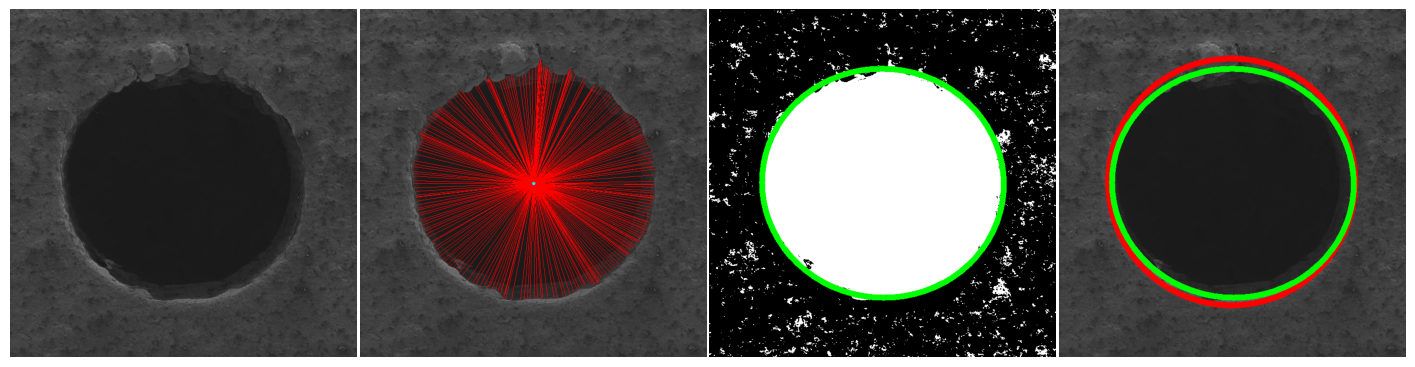

In [ ]:

'''
   --- Enclosing circle ---'''
(center_x, center_y), radius = cv2.minEnclosingCircle(hole_contour);
center = (int(center_x), int(center_y));
radius = int(radius);

'''
   --- Image panels ---'''

# Panel 1: Original SEM image (no fitting)//
panel_original = cv2.cvtColor(sem_image, cv2.COLOR_GRAY2RGB);

# Panel 2: Haralick Distance Lines//
panel_haralick = panel_original.copy();
for i in range(0, len(hole_contour), 4): # subsample to avoid clutter.
    pt = hole_contour[i][0];
    cv2.line(panel_haralick, (cx, cy), tuple(pt), (255, 0, 0), 1);
cv2.circle(panel_haralick, (cx, cy), 3, (0, 255, 255), -1); # centroid.

# Panel 3: Binary image with fitted ellipse//
binary_with_ellipse = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR);
cv2.ellipse(binary_with_ellipse, ellipse, (0, 255, 0), 10);
panel_binary = cv2.cvtColor(binary_with_ellipse, cv2.COLOR_BGR2RGB);

# Panel 4: SEM image with both circle and ellipse//
panel_combined = cv2.cvtColor(sem_image, cv2.COLOR_GRAY2BGR);
cv2.circle(panel_combined, center, radius, (0, 0, 255), 10);
cv2.ellipse(panel_combined, ellipse, (0, 255, 0), 10);
panel_combined = cv2.cvtColor(panel_combined, cv2.COLOR_BGR2RGB);

'''
   --- Plot ---'''
fig, axs = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'wspace': 0.01});

axs[0].imshow(panel_original);
#axs[0].set_title("Original SEM");
axs[0].axis("off");

axs[1].imshow(panel_haralick);
#axs[1].set_title("Haralick Circularity – Distance Profile");
axs[1].axis("off");

axs[2].imshow(panel_binary);
#axs[2].set_title("Binary + Ellipse");
axs[2].axis("off");

axs[3].imshow(panel_combined);
#axs[3].set_title("SEM + Ellipse + Circle");
axs[3].axis("off");

# Save and download the plot//
file_name = "Heat shield hole.svg";
plt.tight_layout(pad=5.0); # Adjust layout to prevent cropping (i.e. Increase padding).
plt.savefig(file_name, format="svg", bbox_inches='tight'); # bbox_inches='tight' to prevent cutting off.
#files.download(file_name); # Download.

plt.tight_layout();
plt.show();


# **Post-correction.**

Tilt angle: 0.32490292642817586
Correction factor: 1.0552065958331638
Corrected image shape: (693, 654)
Hole contour shape: (1059, 1, 2)
Area: 161984.5, Perimeter: 2048.701780319214
Roundness: 2.061931180000989
Mean Distance: 227.66257641284804, Std Dev: 4.710166994198253, Haralick Circularity: 48.334289780653506
Corrected Ellipticity: 1.0079416727376032


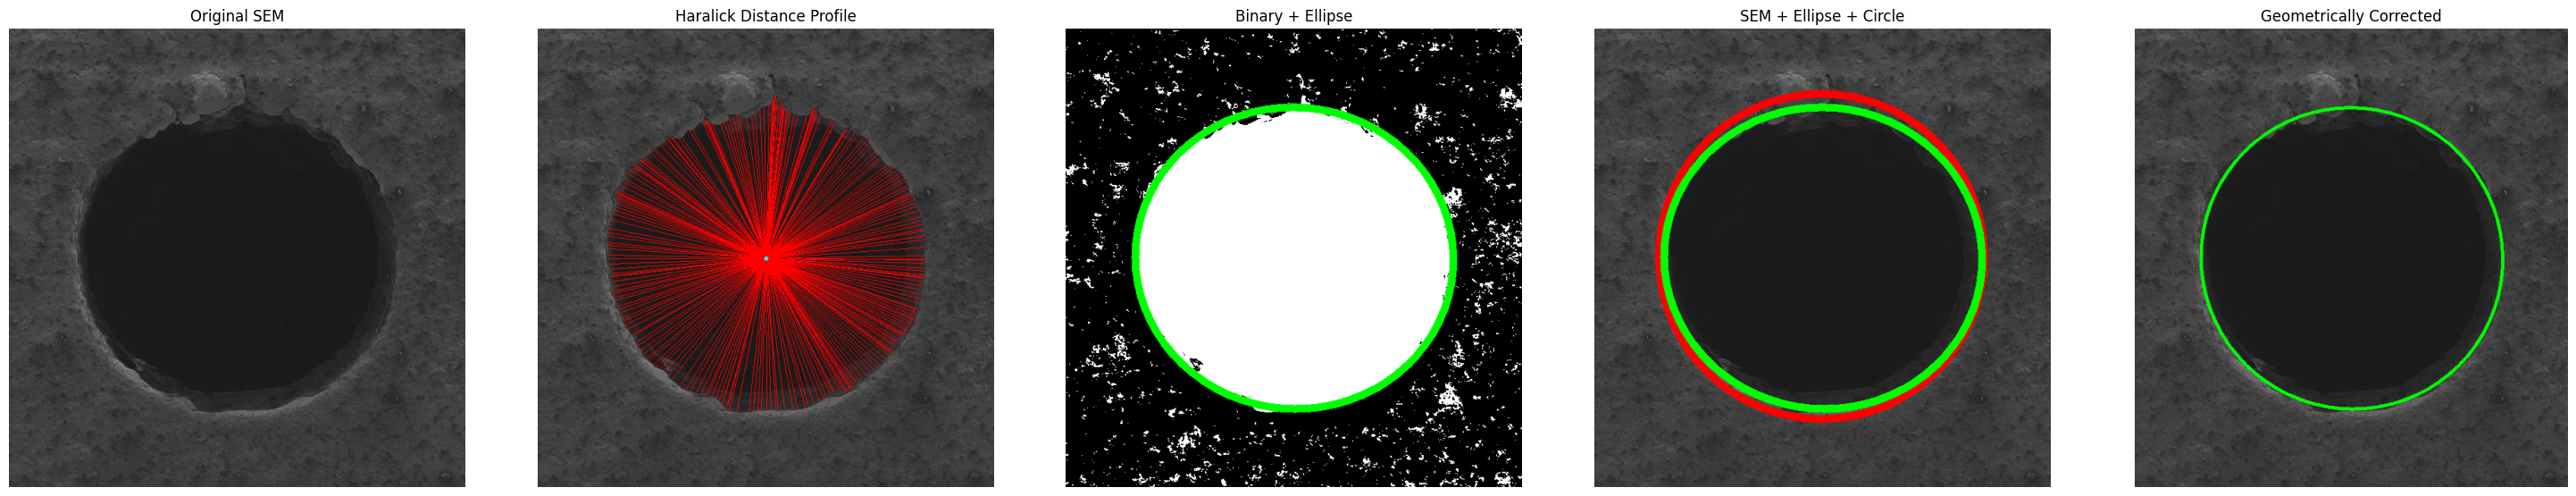

In [ ]:
'''
   --- Geometric Correction ---'''
# Compute tilt angle from ellipse axes//
tilt_angle_rad = np.arccos(np.clip(b / a, 0.0, 1.0)); print(f"Tilt angle: {tilt_angle_rad}");

# Compute affine correction factor//
correction_factor = 1 / np.cos(tilt_angle_rad); print(f"Correction factor: {correction_factor}");

# Apply vertical stretch using cv2.resize//
corrected_image = cv2.resize(sem_image, None, fx=1.0, fy=correction_factor, interpolation=cv2.INTER_LINEAR);
print(f"Corrected image shape: {corrected_image.shape}");

'''
   --- Geometrically correct ---'''
# Re-binarize the corrected image//
_, binary_corr = cv2.threshold(corrected_image, 50, 255, cv2.THRESH_BINARY_INV); #print(f"Binary shape: {binary_corr.shape}");

# Find contours in the binary image//
contours_corr, _ = cv2.findContours(binary_corr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE); #print(f"Contours shape: {len(contours_corr)}");

# Select the largest contour (hole) from the list//
hole_corr = max(contours_corr, key=cv2.contourArea); print(f"Hole contour shape: {hole_corr.shape}");

# Area & perimeter//
area_corr = cv2.contourArea(hole_corr);
perimeter_corr = cv2.arcLength(hole_corr, True); print(f"Area: {area_corr}, Perimeter: {perimeter_corr}");

# Roundness//
roundness_corr = perimeter_corr**2 / (4 * np.pi * area_corr); print(f"Roundness: {roundness_corr}");

# Haralick circularity corrected//
M_corr = cv2.moments(hole_corr);
cx_corr = int(M_corr["m10"] / M_corr["m00"]) if M_corr["m00"] != 0 else 0;
cy_corr = int(M_corr["m01"] / M_corr["m00"]) if M_corr["m00"] != 0 else 0;
distances_corr = [np.sqrt((pt[0][0] - cx_corr)**2 + (pt[0][1] - cy_corr)**2) for pt in hole_corr];

mu_R_corr = np.mean(distances_corr); sigma_R_corr = np.std(distances_corr);
haralick_circularity_corr = mu_R_corr / sigma_R_corr if sigma_R_corr != 0 else float('inf');
print(f"Mean Distance: {mu_R_corr}, Std Dev: {sigma_R_corr}, Haralick Circularity: {haralick_circularity_corr}");

# Ellipticity//
ellipse_corr = cv2.fitEllipse(hole_corr);
(_, _), (major_corr, minor_corr), _ = ellipse_corr;
a_corr = max(major_corr, minor_corr) / 2;
b_corr = min(major_corr, minor_corr) / 2;
ellipticity_corr = a_corr / b_corr;
print(f"Corrected Ellipticity: {ellipticity_corr}");

'''
   --- Plot ---'''
panel_corrected = cv2.cvtColor(corrected_image, cv2.COLOR_GRAY2RGB);
panel_corr_ellipse = panel_corrected.copy();
ellipse_corr = cv2.fitEllipse(hole_corr);
cv2.ellipse(panel_corr_ellipse, ellipse_corr, (0, 255, 0), 4);

fig, axs = plt.subplots(1, 5, figsize=(30, 6));
titles = ["Original SEM", "Haralick Distance Profile", "Binary + Ellipse",
          "SEM + Ellipse + Circle", "Geometrically Corrected"];

panels = [panel_original, panel_haralick, panel_binary, panel_combined, panel_corr_ellipse];

for i in range(5):
    axs[i].imshow(panels[i]);
    axs[i].set_title(titles[i]);
    axs[i].axis("off");

plt.tight_layout(pad=3.0);
file_name = "Geometric_Correction_Analysis.svg";
#plt.savefig(file_name, format="svg", bbox_inches='tight');
plt.show();


# **Deviation.**

In [ ]:
'''
   --- Deviation in diameter --- '''

# Estimate average fitted diameter from corrected ellipse (after resize-based correction)//
fitted_diameter_px = (major_corr + minor_corr) / 2; # in pixels.

# Use original CAD value in micrometers//
cad_diameter_um = 3000.0; # in µm.

# Estimate pixel size based on original (uncorrected) fit//
fitted_diameter_raw_px = (major + minor) / 2;
pixel_size_um = cad_diameter_um / fitted_diameter_raw_px; # µm/pixel.

# Convert corrected diameter to µm//
corrected_diameter_um = fitted_diameter_px * pixel_size_um;
diameter_deviation_um = corrected_diameter_um - cad_diameter_um;

# Round to 3 decimal places//
corrected_diameter_um = round(corrected_diameter_um, 3);
diameter_deviation_um = round(diameter_deviation_um, 3);

print(f"Corrected Diameter (µm): {corrected_diameter_um}, Deviation from CAD (µm): {diameter_deviation_um}");

Corrected Diameter (µm): 3078.069, Deviation from CAD (µm): 78.069
